In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [5]:
batch_size = 32 # for run

transform_train = transforms.Compose(
    [
    # Randomly crop an area, and then resize it to be 32x32
    transforms.RandomResizedCrop(32),
    # Randomly flip the image horizontally
     transforms.RandomHorizontalFlip(),
    # Randomly jitter the brightness, contrast and saturation of the image
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    # Transpose the image from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    transforms.ToTensor(),
    # Normalize the image with mean and standard deviation calculated across all images
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ])

transform_test = transforms.Compose(
    [
    # Randomly crop an area, and then resize it to be 32x32
    transforms.RandomResizedCrop(32),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
datagen_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
datagen_test = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Let's see what we are trying to classify: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 bird   cat  bird horse  deer   cat  frog  ship  ship horse   car   cat   car  deer  frog plane  ship  frog truck plane  frog horse  deer  frog plane  bird  deer  deer  deer  deer   cat horse


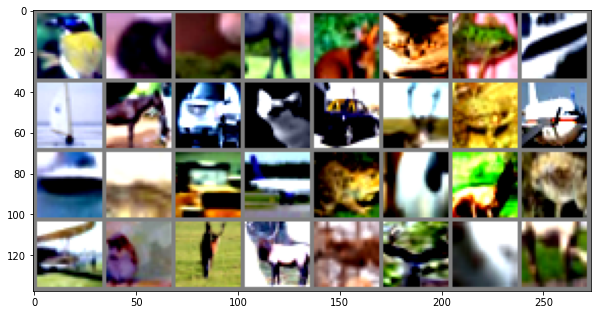

In [22]:
def show_grid(img):
    fig = figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    img = img / 2 + 0.5     # approx unnormalize
    ax.imshow(np.transpose(img,[1, 2, 0]))


# get some random training images
dataiter = iter(datagen_train)
images, labels = dataiter.next()

# show images
show_grid(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
import torch.nn as nn
import torch.nn.functional as F



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Train the network


In [7]:
# Evaluate accuracy manually 
def get_accuracy():

    correct = 0
    total = 0
    with torch.no_grad(): # alternatively net.eval()
        for data in datagen_test:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [10]:
for epoch in range(5):  # loop over the dataset multiple times
    tic = time.time()
    net.train() # Set network in training mode 
    train_loss = 0.0
    for i, data in enumerate(datagen_train):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels=labels.to(device)

        # zero the parameter gradients manually
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
    net.eval() # Set network in evaluation mode
    acc = get_accuracy()
    print('Epoch {} loss={} val acc={} time={}'.format(epoch,  train_loss / len(datagen_train), acc , time.time()-tic))


print('Finished Training')

Epoch 0 loss=1.5578150078797295 val acc=43.91 time=10.834558963775635
Epoch 1 loss=1.522344634461235 val acc=44.89 time=10.996520280838013
Epoch 2 loss=1.5192071622331709 val acc=45.67 time=10.840695142745972
Epoch 3 loss=1.5031157975309717 val acc=45.89 time=10.856968879699707
Epoch 4 loss=1.4981939862801033 val acc=44.97 time=10.713194131851196
Finished Training


# Save/load network 

In [ ]:
torch.save(net.state_dict(), 'myfirstNet.params')
net.load_state_dict(torch.load('myfirstNet.params'))

## MultiGPU example

In [11]:
net = nn.DataParallel(net) # that was it, it finds automatically all available GPUs 
# For production prefer DistributedDataParallel
# https://pytorch.org/docs/stable/generated/torch.nn.parallel.DistributedDataParallel.html

In [13]:
for epoch in range(3):  # loop over the dataset multiple times
    tic = time.time()
    net.train()
    train_loss = 0.0
    for i, data in enumerate(datagen_train):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels=labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
    net.eval()
    acc = get_accuracy()
    print('Epoch {} loss={} val acc={} time={}'.format(epoch,  train_loss / len(datagen_train), acc, time.time()-tic))


print('Finished Training')

Epoch 0 loss=1.4617785468974025 val acc=47.45 time=10.891917705535889
Epoch 1 loss=1.454574838862233 val acc=48.17 time=10.70172381401062
Epoch 2 loss=1.4533558444418513 val acc=48.31 time=10.791701316833496
Finished Training
